In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

C:\Users\2010y\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def preprocess_civil(filename)->pd.DataFrame:
    """
    Reads given filename and places the right column name for even rows and odd rows.
    After giving the right column name, merge even rows and odd rows to have them in one row.

    :param filename: filename as a string like: "09905-0002-Data.txt"
    :return: cleaned pd.DataFrame

    >>> preprocess_civil("09905-0002-Data.txt")['war number'].iloc[0]
    601

    >>> preprocess_civil("09905-0002-Data.txt")['fatalities'].iloc[0]
    7000
    """
    data = pd.read_csv(filename, header=None, delimiter=r"\s+")
    even = data.iloc[::2] #even rows dataframe
    odd = data.iloc[1::2] #odd rows dataframe
    odd = odd.iloc[:, :-4] #get rid of columns of NAs
    even.columns=[
    'war number', 'Singer-Small country code', 'year of war start', 'month of war start', 'day of war start',
    'year of war end', 'month of war end', 'day of war end', 'year of second war start', 'month of second war start',
    'day of second war start', 'year of second war end', 'month of second war end', 'day of second war end',
    'year of third war start', 'month of third war start', 'day of third war start', 'year of third war end',
    'month of third war end', 'day of third war end'
    ]
    odd.columns=[
    'outside intervention', 'fought in member of central sub-system', 'fought in major power', 'outcome of war',
    'western hemisphere', 'europe', 'africa', 'middle east', 'asia', 'oceania', 'fatalities', 'duration',
    'population before war', 'military', 'system membership', 'intervened by'
    ]
    even=even.reset_index(drop=True)
    odd = odd.reset_index(drop=True)
    civilwar = even.merge(odd, left_index=True, right_index=True)
    return civilwar

In [3]:
def preprocess_civilcodebook(filename) -> pd.DataFrame:
    """
    Read codebook to map the 'Singer-Small country code' to the country name

    :param filename: filename as a string like "09905-Codebook.txt"
    :return: cleaned pd.DataFrame

    >>> preprocess_civilcodebook("09905-Codebook.txt")['country'].iloc[0]
    'SPAIN'

    >>> preprocess_civilcodebook("09905-Codebook.txt")['war number'].iloc[0]
    601

    """
    with open(filename) as f:
        lines=f.readlines()
        x1=[]
        x2=[]
        for i in lines[1316:1467]:
            try:
                start_index=i.index('   ')
                end_index=i.index('(')
            except ValueError:
                continue
            x1.append(i[1:4])
            x2.append(re.sub(r" ?\[[^)]+\]", "", i[start_index:end_index].strip()))
            df=pd.DataFrame(x1, x2, columns=['war number'])
            df.reset_index(inplace=True)
            df=df.rename(columns={'index': 'country'})
            df['war number'] = df['war number'].astype(int)
        return df

In [4]:
def merge_civil_codebook(civil, codebook)->pd.DataFrame:
    """
    Takes cleaned civil war data and codebook and merge two DataFrames.
    In civil war data, the year was recorded without 1000.
    For instance, 1801 was recorded as 801.
    For compatibility, this function add 1000 to changes the year into 1801.

    :param civil: a pd.DataFrame from preprocess_civil() function
    :param codebook: a pd.DataFrame from preprocess_civilcodebook() function
    :return: a merged pd.DataFrame

    >>> merge_civil_codebook(civil, df)['year of war start'].iloc[0]
    1821

    >>> merge_civil_codebook(civil, df)['year of war end'].iloc[0]
    1823
    """

    #In the codebook, warnumber 601 is not recorded but it exists in the data
    #We lose 2 records. In total, we have 202 cases
    coded=civil.merge(codebook, left_on='war number', right_on='war number')
    #change the year
    coded['year of war start'] += 1000
    coded['year of war end'] += 1000
    for idx, row in coded.iterrows():
        if row['year of second war end'] != 0:
            coded['year of war end'].iloc[idx] = row['year of second war end'] + 1000
        else:
            continue
    coded=coded.drop(columns=['year of second war start', 'year of second war end',
                              'year of third war start', 'year of third war end'], axis=1)
    return coded

In [5]:
def control_country(coded)-> pd.DataFrame:
    """
    Takes cleaned pd.DataFrame from merge_civil_codebook() and control the country name
    1) Correct typos
    2) Match the country names between pd.DataFrame from democracy data
    e.g., LAOS into Lao Pdr, SOUTH YEMEN into Yemen Pdr

    :param coded: a pd.DataFrame after merging codebook and civil data
    :return: a pd.DataFrame changed the country name

    >>> control_country(coded)['country'].iloc[54]
    'RUSSIAN FEDERATION'

    """
    for idx, val in coded.iterrows():
        #for Austria-hungary I splited into two countries. So we have 203 records
        if val['country']=='AUSTRIA-HUNGARY':
            val[4]='AUSTRIA'
            coded.loc[len(coded)]=val
            val[4]='HUNGARY'
            coded.loc[len(coded)]=val
            coded=coded.drop(idx)
        if val['country']=='BRUNDI':
            val[4]='BURUNDI'
            coded.loc[idx]=val
        if val['country']=='FINNISH':
            val[4]='FINLAND'
            coded.loc[idx]=val
        if val['country']=='RUMANIA':
            val[4]='ROMANIA'
            coded.loc[idx]=val
        if val['country']=='TURKEY/OTTOMAN EMPIRE':
            val[4]='TURKEY'
            coded.loc[idx]=val
        if val['country']=='UGANDAN':
            val[4]='UGANDA'
            coded.loc[idx]=val
        if val['country']=='RUSSIA/SOVIET UNION':
            val[4]='RUSSIA'
            coded.loc[idx]=val
        if val['country']=='KAMPUCHEA':
            val[4]='CAMBODIA'
            coded.loc[idx]=val
        #name matching with democracy dataset
        if val['country']=='BOSNIA':
            val[4]='Bosnia and Herzegov'
            coded.loc[idx]=val
        if val['country']=='BURMA':
            val[4]='Myanmar'
            coded.loc[idx]=val
        if val['country']=='IRAN':
            val[4]='Iran, Islamic Rep'
            coded.loc[idx]=val
        if val['country']=='LAOS':
            val[4]='Lao Pdr'
            coded.loc[idx]=val
        if val['country']=='RUSSIA':
            val[4]='Russian Federation'
            coded.loc[idx]=val
        if val['country']=='SOUTH YEMEN':
            val[4]='Yemen Pdr'
            coded.loc[idx]=val
        if val['country']=='UNITED STATES OF AMERICA':
            val[4]='United States'
            coded.loc[idx]=val
        if val['country']=='TAKJIKISTAN':
            val[4]='Tajikistan'
            coded.loc[idx]=val
        if val['country']=='VIETNAM, REPUBLIC OF':
            val[4]='Vietnam, North'
            coded.loc[idx]=val
        if val['country']=='YEMEN ARAB REPUBLIC':
            val[4]='Yemen, Rep.'
            coded.loc[idx]=val
    coded['country']=coded['country'].str.upper()
    coded=coded.rename(columns={'country':'ctryname'})
    coded.reset_index(drop=True)
    return coded

In [6]:
def preprocess_democracy(filename)-> pd.DataFrame:
    """
    Reads filename and if democracy index is NA and liberty index is NA, get rid of the rows.

    :param filename: a string like "20440-0001-Data.tsv"
    :return: a cleaned pd.DataFrame

    >>> preprocess_democracy("20440-0001-Data.tsv")['ctryname'].loc[15634]
    'FIJI'

    """
    #SARDINA is not in the democracy data file
    democracy=pd.read_csv(filename, sep='\t')
    democracy['ctryname']=democracy['ctryname'].str.upper()
    ###delete
    democ_index=democracy[democracy['democ']!='-99']
    democ_index=democ_index[democ_index['democ']!='-88']
    democ_index=democ_index[democ_index['democ']!='-77']
    democ_index=democ_index[democ_index['democ']!='-66']
    democ_index=democ_index[democ_index['democ']!='-55']
    democ_index=democ_index[democ_index['democ']!= ' ']
    ###
    democ_index=democ_index[democ_index['liberty']!= ' ']
    democ_index=democ_index[democ_index['liberty']!= '-99']
    return democ_index

In [7]:
def join_df_democ(coded, democ_index, restore_year)-> pd.DataFrame:
    """
    Reads two pd.DataFrames from civil war data and democracy data
    After joining two pd.DataFrames, calculate the changes in democracy score after given restore_year

    :param coded: a pd.DataFrame from control_country() function
    :param democ_index: a pd.DataFrame from preprocess_democracy() function
    :param restore_year: the number of years to be considered as a buffer to give restoration from civil war
    :return: a pd.DataFrame

    >>>join_df_democ(coded, democ_index, restore_year)['delta'].loc[4]
    3
    >>>join_df_democ(coded, democ_index, restore_year)['ratio'].loc[4]
    0.00583941605839416

    """
    dfcols=['ctryname', 'score before year', 'score before', 'fatal', 'pop', 'ratio', 'score after year', 'score after', 'delta']
    df=pd.DataFrame(columns=dfcols)
    for idx, val in coded.iterrows():
        if val['ctryname'] in democ_index['ctryname'].values:
            try:
                df=df.append(
                pd.Series(
                    [val['ctryname'],
                    val['year of war start'],
                    democ_index[(democ_index['ctryname']==val['ctryname']) & (democ_index['year']==val['year of war start'])]['democ'].to_numpy()[0],
                    val['fatalities'],
                    democ_index[(democ_index['ctryname']==val['ctryname']) & (democ_index['year']==val['year of war start'])]['poptotal'].to_numpy()[0],
                    0,
                    val['year of war end']+restore_year,
                    democ_index[(democ_index['ctryname']==val['ctryname']) & (democ_index['year']==val['year of war end']+restore_year)]['democ'].to_numpy()[0],
                    0
                    ], index=dfcols), ignore_index=True)
            except IndexError:
                continue
    for idx, val in df.iterrows():
        val['pop']=val['pop']+'000'
        try:
            df['score before'][idx]=int(df['score before'][idx][0])
        except IndexError:
            df['score before'][idx]=0
        try:
            df['score after'][idx]=int(df['score after'][idx][0])
        except IndexError:
            df['score after'][idx]=0
        try:
            val['ratio']=float(val['fatal'])/float(val['pop'])
        except:
            val['ratio']=0
    df['delta']=df['score after']-df['score before']
    return df

In [8]:
def join_df_liberty(coded, democ_index, restore_year)->pd.DataFrame:
    """
    Reads two pd.DataFrames from civil war data and democracy data
    After joining two pd.DataFrames, calculate the changes in liberty score after given restore_year

    :param coded: a pd.DataFrame from control_country() function
    :param democ_index: a pd.DataFrame from preprocess_democracy() function
    :param restore_year: the number of years to be considered as a buffer to give restoration from civil war
    :return: a pd.DataFrame

    >>>join_df_liberty(coded, democ_index, restore_year)['delta'].loc[3]
    0
    >>>join_df_liberty(coded, democ_index, restore_year)['ratio'].loc[3]
    0.00018541409147095178
    """
    dfcols=['ctryname', 'score before year', 'score before', 'fatal', 'pop', 'ratio', 'score after year', 'score after', 'delta']
    df=pd.DataFrame(columns=dfcols)
    for idx, val in coded.iterrows():
        if val['ctryname'] in democ_index['ctryname'].values:
            try:
                df=df.append(
                pd.Series(
                    [val['ctryname'],
                    val['year of war start'],
                    democ_index[(democ_index['ctryname']==val['ctryname']) & (democ_index['year']==val['year of war start'])]['liberty'].to_numpy()[0],
                    val['fatalities'],
                    democ_index[(democ_index['ctryname']==val['ctryname']) & (democ_index['year']==val['year of war start'])]['poptotal'].to_numpy()[0],
                    0,
                    val['year of war end']+restore_year,
                    democ_index[(democ_index['ctryname']==val['ctryname']) & (democ_index['year']==val['year of war end']+restore_year)]['liberty'].to_numpy()[0],
                    0
                    ], index=dfcols), ignore_index=True)
            except IndexError:
                continue
    for idx, val in df.iterrows():
        val['pop']=val['pop']+'000'
        try:
            val['ratio']=float(val['fatal'])/float(val['pop'])
        except:
            val['ratio']=0
    df['delta']=df['score after'].astype(float)-df['score before'].astype(float)
    df['pop']=df['pop']
    return df

In [9]:
civil=preprocess_civil("09905-0002-Data.txt")[['war number', 'fatalities', 'year of war start',
               'year of war end', 'year of second war start',
               'year of second war end', 'year of third war start',
               'year of third war end']]

In [10]:
df=preprocess_civilcodebook("09905-Codebook.txt")

In [11]:
coded=merge_civil_codebook(civil, df)

C:\Users\2010y\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [12]:
coded.head(5)

,war number,fatalities,year of war start,year of war end,country
0,601,7000,1821,1823,SPAIN
1,602,2000,1820,1821,TWO SICILIES
2,602,0,1821,1821,TWO SICILIES
3,603,1000,1821,1821,SARDINIA
4,603,0,1821,1821,SARDINIA


In [13]:
coded=control_country(coded)

In [14]:
democ_index=preprocess_democracy("20440-0001-Data.tsv")

C:\Users\2010y\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (0,2,3,6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


C:\Users\2010y\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\2010y\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\2010y\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


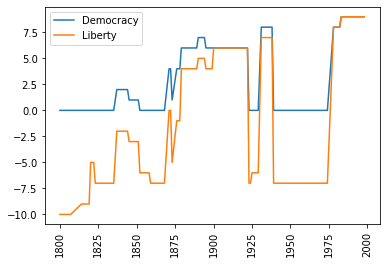

In [15]:
plt.plot(pd.to_numeric(democ_index[democ_index['ctryname']=='SPAIN']['year']),
        democ_index[democ_index['ctryname']=='SPAIN']['democ'].astype(int),
        label='Democracy')
plt.plot(pd.to_numeric(democ_index[democ_index['ctryname']=='SPAIN']['year']),
        democ_index[democ_index['ctryname']=='SPAIN']['liberty'].astype(int),
        label='Liberty')
plt.xticks(rotation = 90)
plt.legend()
plt.show()
#t-test will show the difference between two scores.

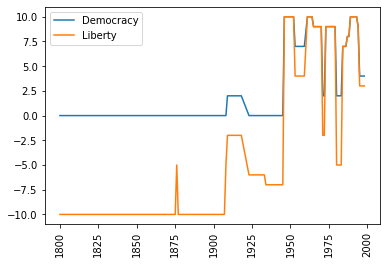

In [16]:
plt.plot(pd.to_numeric(democ_index[democ_index['ctryname']=='TURKEY']['year']),
        democ_index[democ_index['ctryname']=='TURKEY']['democ'].astype(int),
        label='Democracy')
plt.plot(pd.to_numeric(democ_index[democ_index['ctryname']=='TURKEY']['year']),
        democ_index[democ_index['ctryname']=='TURKEY']['liberty'].astype(int),
        label='Liberty')
plt.xticks(rotation = 90)
plt.legend()
plt.savefig('TURKEY')
plt.show()

In [17]:
count_total_fatalities=coded.groupby(['ctryname','fatalities']).size()
total_fatalities=pd.DataFrame(count_total_fatalities, columns=['counts'])
total_fatalities.reset_index(inplace=True)
total_fatalities['total']=total_fatalities['fatalities'].astype(int) * total_fatalities['counts'].astype(int)

In [18]:
fatalities_per_country=pd.DataFrame(total_fatalities.groupby('ctryname')['total'].sum().reset_index())

In [19]:
fatalities_per_country['t-test']=np.NaN

In [20]:
for idx, val in fatalities_per_country.iterrows():
    fatalities_per_country['t-test'].loc[idx]="{:.3f}".format(stats.ttest_ind(democ_index[democ_index['ctryname']==val['ctryname']]['liberty'].astype(int),
               democ_index[democ_index['ctryname']==val['ctryname']]['democ'].astype(int))[1])

C:\Users\2010y\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [21]:
fatalities_per_country.sort_values(by='total', ascending=False)

,ctryname,total,t-test
12,CHINA,3497525,0.000
0,AFGHANISTAN,1064000,0.000
39,NIGERIA,1006000,0.000
50,SPAIN,708850,0.000
57,UNITED STATES,651000,0.111
...,...,...,...
58,URUGUAY,1000,0.000
20,GEORGIA,1000,0.001
23,HONDURAS,1000,0.000
48,SARDINIA,1000,nan


In [22]:
df5=join_df_democ(coded, democ_index, 5)

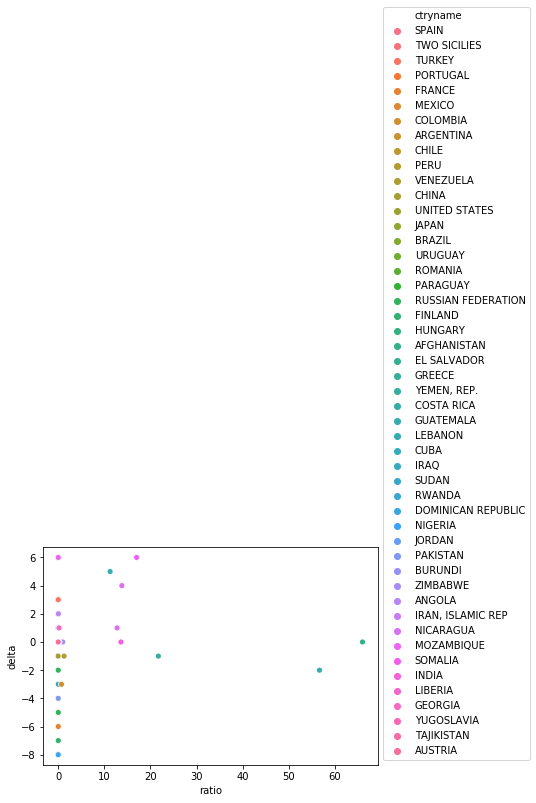

In [23]:
import seaborn as sns
sns.scatterplot('ratio', 'delta', data=df5, hue='ctryname')
plt.legend(bbox_to_anchor=(1, 0), loc='lower left', ncol=1)
plt.show()

In [24]:
x5=df5['ratio'].to_numpy().astype('int64')
y5=df5['delta'].to_numpy().astype('int64')
res_5yr=stats.linregress(x5, y5)
print("Slope is: {}\nP-value is: {}".format(res_5yr.slope, res_5yr.pvalue))

Slope is: 0.01810697250833288
P-value is: 0.5243109627718738


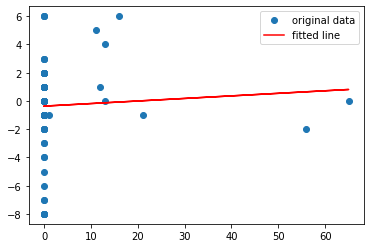

In [25]:
plt.plot(x5, y5, 'o', label='original data')
plt.plot(x5, res_5yr.intercept + res_5yr.slope*x5, 'r', label='fitted line')
plt.legend()
plt.show()

In [26]:
df10=join_df_democ(coded, democ_index, 10)

In [27]:
x10=df10['ratio'].to_numpy().astype('int64')
y10=df10['delta'].to_numpy().astype('int64')
res_10yr=stats.linregress(x10, y10)
print("Slope is: {}\nP-value is: {}".format(res_10yr.slope, res_10yr.pvalue))

Slope is: 0.1324756134010814
P-value is: 0.23916307803596604


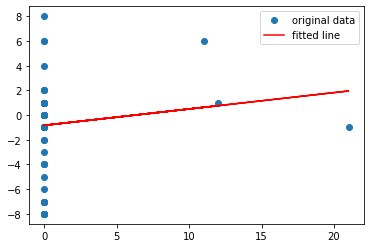

In [28]:
plt.plot(x10, y10, 'o', label='original data')
plt.plot(x10, res_10yr.intercept + res_10yr.slope*x10, 'r', label='fitted line')
plt.legend()
plt.show()

In [29]:
df20=join_df_democ(coded, democ_index, 20)

In [30]:
x20=df20['ratio'].to_numpy().astype('int64')
y20=df20['delta'].to_numpy().astype('int64')
res_20yr=stats.linregress(x20, y20)
print("Slope is: {}\nP-value is: {}".format(res_20yr.slope, res_20yr.pvalue))

Slope is: -0.35839598997493677
P-value is: 0.012355336512536263


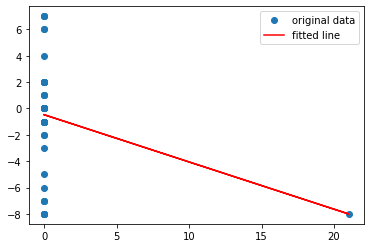

In [31]:
plt.plot(x20, y20, 'o', label='original data')
plt.plot(x20, res_20yr.intercept + res_20yr.slope*x20, 'r', label='fitted line')
plt.legend()
plt.show()

In [32]:
df5l=join_df_liberty(coded, democ_index, 5)

In [33]:
x5l=df5l['ratio'].to_numpy().astype('int64')
y5l=df5l['delta'].to_numpy().astype('int64')
res_5yrl=stats.linregress(x5l, y5l)
print("Slope is: {}\nP-value is: {}".format(res_5yrl.slope, res_5yrl.pvalue))

Slope is: 0.02950823577270035
P-value is: 0.6174520231542439


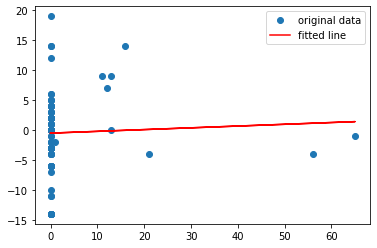

In [34]:
plt.plot(x5l, y5l, 'o', label='original data')
plt.plot(x5l, res_5yrl.intercept + res_5yrl.slope*x5l, 'r', label='fitted line')
plt.legend()
plt.show()

In [35]:
df10l=join_df_liberty(coded, democ_index, 10)

In [36]:
x10l=df10l['ratio'].to_numpy().astype('int64')
y10l=df10l['delta'].to_numpy().astype('int64')
res_10yrl=stats.linregress(x10l, y10l)
print("Slope is: {}\nP-value is: {}".format(res_10yrl.slope, res_10yrl.pvalue))

Slope is: 0.23701872129989382
P-value is: 0.2916737758655891


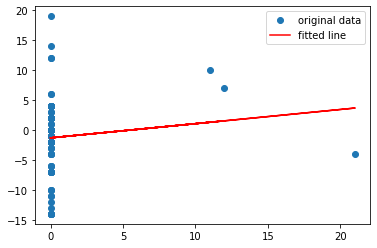

In [37]:
plt.plot(x10l, y10l, 'o', label='original data')
plt.plot(x10l, res_10yrl.intercept + res_10yrl.slope*x10l, 'r', label='fitted line')
plt.legend()
plt.show()

In [38]:
df20l=join_df_liberty(coded, democ_index, 20)

In [39]:
x20l=df20l['ratio'].to_numpy().astype('int64')
y20l=df20l['delta'].to_numpy().astype('int64')
res_20yrl=stats.linregress(x20l, y20l)
print("Slope is: {}\nP-value is: {}".format(res_20yrl.slope, res_20yrl.pvalue))

Slope is: -0.6646616541353384
P-value is: 0.016353211850856707


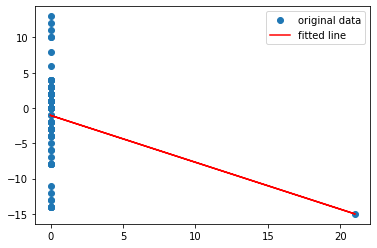

In [40]:
plt.plot(x20l, y20l, 'o', label='original data')
plt.plot(x20l, res_20yrl.intercept + res_20yrl.slope*x20l, 'r', label='fitted line')
plt.legend()
plt.show()